In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt


## AB Testing in Python

This is an example that explains AB Testing through an example that models **click through rates** of 2 different interfaces.

p_A_true and p_B_true are the **true observed values** of A and B.

We are now simulating values from a bernoulli distribution with the values of **p** as A_true and B_true

In [22]:
# true value of p_A and p_B (unknown)
p_A_true = 0.05 #Probability of click through rates in set up A
p_B_true = 0.04 #Probability of click through rates in set up B

# number of users visiting page A and B
N_A = 1500
N_B = 700

occurrences_A = pm.rbernoulli(p_A_true, N_A)
occurrences_B = pm.rbernoulli(p_B_true, N_B)


print ('Observed frequency for A:',sum(occurrences_A))
print ('Observed frequency for B:',sum(occurrences_B))

Observed frequency for A: 79
Observed frequency for B: 57


Now we will define our prior distributions, which is a Uniform distribution. This implies that we don't have any prior imformation. We also capture the difference between the probabilities of A and B

In [18]:
p_A = pm.Uniform('p_A', lower=0, upper=1)
p_B = pm.Uniform('p_B', lower=0, upper=1)

@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

obs_A = pm.Bernoulli('obs_A', p_A, value=occurrences_A, observed=True)
obs_B = pm.Bernoulli('obs_B', p_B, value=occurrences_B, observed=True)

In [8]:
obs_A

<pymc.distributions.new_dist_class.<locals>.new_class 'obs_A' at 0x0000023462439358>

In [21]:
# defining a Monte Carlo Markov Chain model
mcmc = pm.MCMC([p_A, p_B, obs_A, obs_B, delta])

# setting the size of the simulations
mcmc.sample(250000, 50000) # Sample for 25000 and burn the first 5000

# the resulting posterior distributions are stored in trace variables
p_A_samples = mcmc.trace('p_A')[:]
p_B_samples = mcmc.trace('p_B')[:]
delta_samples = mcmc.trace('delta')[:]

 [-----------------100%-----------------] 250000 of 250000 complete in 49.7 sec

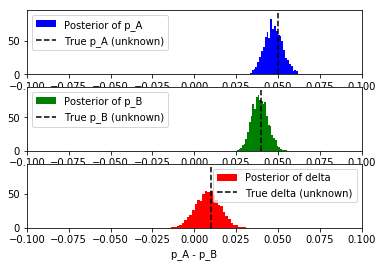

In [20]:
plt.subplot(3,1,1)
plt.xlim(-0.1, 0.1)
plt.hist(p_A_samples, bins=35, histtype='stepfilled', density=True,color='blue', label='Posterior of p_A')
plt.vlines(p_A_true, 0, 90, linestyle='--', label='True p_A (unknown)')
plt.xlabel('Probability of clicking BUY via A')
plt.legend()

plt.subplot(3,1,2)
plt.xlim(-0.1, 0.1)
plt.hist(p_B_samples, bins=35, histtype='stepfilled', density=True,color='green', label='Posterior of p_B')
plt.vlines(p_B_true, 0, 90, linestyle='--', label='True p_B (unknown)')
plt.xlabel('Probability of clicking BUY via B')
plt.legend()

plt.subplot(3,1,3)
plt.xlim(-0.1, 0.1)
plt.hist(delta_samples, bins=35, histtype='stepfilled', density=True,color='red', label='Posterior of delta')
plt.vlines(p_A_true - p_B_true, 0, 90, linestyle='--', label='True delta (unknown)')
plt.xlabel('p_A - p_B')
plt.legend()
plt.show()

In [45]:
print ('Probability that p_A > p_B:')
print ((delta_samples > 0).mean())

Probability that p_A > p_B:
0.85854
